# Links to each features

Go to <a href=#Functions>Functions</a>

Go to [Data Exploring](#Data-Exploring)

Go to [ID and Class](#ID-and-Class)

Go to [Features EDA](#Features-EDA)

# Breast Cancer Detection

In [2]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objs as go
# import plotly.tools as tls
# from plotly.offline import iplot, init_notebook_mode
# import plotly.figure_factory as ff

# Functions <a name='Functions' />

In [32]:
# Function to show data information
def summary_table(df, target_df=None):
    '''
    Make a summary table with features as rows. Put .transpose() if feature list is short.
    '''
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['uniques'] = df.nunique().values
    summary['min'] = [df[col].min() if df[col].dtype !='O' else '-' for col in df.columns ]
    summary['max'] = [df[col].max() if df[col].dtype !='O' else '-' for col in df.columns ]
    index_df = pd.DataFrame()
    count_df = pd.DataFrame()
    for col in df.columns:
        val_ct = df[col].value_counts()
        index_df[col]= [val_ct.index[i] if i<len(val_ct) else '-' for i in range(3)]
        count_df[col]= [val_ct.values[i] if i<len(val_ct) else '-' for i in range(3)]
    summary['top'] = index_df.loc[0].values
    summary['1-freq'] = count_df.loc[0].values
    summary['2nd most'] = index_df.loc[1].values
    summary['2-freq'] = count_df.loc[1].values
    summary['3rd most'] = index_df.loc[2].values
    summary['3-freq'] = count_df.loc[2].values
    if target_df is not None:
        Frd_ratio = []
        for col in df.columns:
            tmp = target_df[df[col].notna()]
            Frd_ratio.append(np.round((tmp==1).sum()/len(tmp),decimals=3))
        summary['Frd ratio']  = Frd_ratio
#     summary['top'] = [df[col].value_counts(dropna=False).index[0] for col in df.columns]
#     summary['freq'] = [df[col].value_counts(dropna=False).values[0] for col in df.columns]

    summary.set_index('Name', inplace = True)
    summary = summary.rename_axis(None)
    return summary

In [119]:
# Function to plot the statistics for categorical data
def bar_plot(df, feature, target = target, fill_na = 'null', others_threshold = 10, 
             target_plots =True, xtick_rotate = False, reduced = False, box_plot = False, sorted_plot_order = False):
#     if sorted_plot_order:
#         assert (type(fill_na) == np.int)|(type(fill_na) == np.float), 'fill_na should be number for sorted_plot_order'
    y_label = 'Malignant'
    total_num = len(df)
    if feature != target:
        df_trans = df[[target, feature]].copy()
        if fill_na is not None:
            df_trans[feature] = df_trans[feature].fillna(fill_na)

            
        df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
                    [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
                     , feature] = "others"
    

        tmp = pd.crosstab(df_trans[feature], df_trans[target], normalize='index') * 100
        tmp.reset_index(inplace = True)
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    
    elif feature == target:
        target_plots = False
        df_trans = df[[feature]].copy()
    

    if sorted_plot_order:
        str_val = []
        num_val = []
        for value in df_trans[feature].unique():
            if type(value) == np.str:
                str_val.append(value)
            else:
                num_val.append(value)
        plot_order = list(np.sort(str_val))+list(np.sort(num_val))
    else:
        plot_order = df_trans[feature].value_counts().keys()
      
                
    plt.figure(figsize=(14,13))
    if target_plots & (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    plt.suptitle(f'{feature} Distributions', fontsize=22, y=title_y)
        
    plt.subplot(321)
    g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
    heights = []
    for p in g.patches:
        height = p.get_height()
        heights.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_num*100),
                ha="center", fontsize=14)
    g.set_ylim(0, max(heights) *1.1 )

    if (target_plots) & (not reduced):
        plt.subplot(322)
        g2 = sns.countplot(x=feature, hue=target, data=df_trans, order = plot_order)

        g2_pt = g2.twinx()
        g2_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g2_pt.set_ylabel(f"% of {y_label} (Counts)", fontsize=16)

        g2.set_title(f"Frequency by Target({target})", fontsize=19)
        g2.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha="right")
        g2.set_ylabel("Count", fontsize=17)

    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()



In [135]:

# Function to plot Histograms for float valued features
def dist_plot(df, feature, Price = target, fill_nan = False ,bin_num = 30 , df_test=pd.DataFrame(),\
              TransAmt_plot = False):
    plt.figure(figsize=(14,8))
    plt.suptitle(f'{feature} Distributions', fontsize=22)
    TransAmt = (feature == Price)
    if len(df_test) == 0:
        if TransAmt:
            df_trans = df[[ Price]].copy()
        else:
            df_trans = df[[ feature, Price]].copy()
        if fill_nan:
            df_trans[feature].fillna(df_trans[feature].mean(), inplace = True)


        plt.subplot(211)


        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False)


#         g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

        
    elif len(df_test)>0:
        df_trans = df[[ feature, Price]].copy()
        df_test = df_test[[ feature]].copy()
        if fill_nan:
            df_trans[[feature]].fillna(df_trans.mean(), inplace = True)
            df_test[[feature]].fillna(df_trans.mean(), inplace = True)
            
        plt.subplot(211)

#         bin_num = 30

        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False, label='train')
        bin_width = next(iter(g.patches)).get_width()
        bin_arr = np.arange(df_test[feature].min(), df_test[feature].max(), bin_width)
        g = sns.distplot(df_test[feature], bins=bin_arr, kde=False, label='test')
      
        
        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

    if (TransAmt ==False)&(TransAmt_plot):
        plt.subplot(212)

        g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
                          hist_kws={'weights': df_trans[Price][df_trans[feature].notna()]})

        g2.set_title(f"{feature} {Price}", fontsize=20)
        g2.set_xlabel(f"{feature} Values", fontsize=18)
        g2.set_ylabel(f"{Price} $ by bin", fontsize=18)


    plt.subplots_adjust(hspace = 0.6, top = 0.85)
#         plt.tight_layout()
    plt.show()

In [54]:
def scatter_plot(df, col,col2 = 'TransactionDT', df_test = pd.DataFrame(), scatter_size = 5):
#     if len(df_test)>0:
#         df = pd.concat([df_train[[col2,col]],df_test[[col2,col]]],axis=0,sort=False)
#     else:
#         df = df_train
    plt.figure(figsize=(15,4))
    plt.scatter(df.TransactionDT,df[col], label='train', s = scatter_size**2)
    if len(df_test)>0:
        plt.scatter(df_test.TransactionDT,df_test[col], label='test', s = scatter_size**2)
    plt.title(f'{col} over TransactionDT', fontsize =20)
    plt.xlabel('TransactionDT', fontsize =18)
    plt.ylabel(f'{col}' , fontsize =18)
    plt.legend()
    plt.show()

# Data Exploring

In [87]:
df = pd.read_csv('Breast-cancer-wisconsin.txt')

In [88]:
df

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
15850,15850,1169049,7,3,4,4,3,3,3,2,7,4
15851,15851,1076352,3,6,4,10,3,3,3,4,1,4
15852,15852,1107684,6,10,5,5,4,10,6,10,1,4
15853,15853,1111249,10,6,6,3,4,5,3,6,1,4


In [20]:
df['Class'].value_counts()

4          15164
2            456
40           151
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

In [89]:
df['Class'] = df['Class'].apply(lambda x: 0 if x=='2' else (1 if x=='4' else 2)).astype('int8')

In [90]:
target = 'Class'

In [91]:
df.drop(columns = 'Index',inplace = True)

In [50]:
# df.rename(columns = {'Class':'label'}, inplace = True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           15855 non-null  int64 
 1   Clump Thickness              15855 non-null  int64 
 2   Uniformity of Cell Size      15827 non-null  object
 3   Uniformity of Cell Shape     15827 non-null  object
 4   Marginal Adhesion            15827 non-null  object
 5   Single Epithelial Cell Size  15827 non-null  object
 6   Bare Nuclei                  15827 non-null  object
 7   Bland Chromatin              15827 non-null  object
 8   Normal Nucleoli              15827 non-null  object
 9   Mitoses                      15827 non-null  object
 10  Class                        15855 non-null  int8  
dtypes: int64(2), int8(1), object(8)
memory usage: 1.2+ MB


## Let's take a look at the data

In [93]:
list(df.columns)

['ID',
 'Clump Thickness',
 'Uniformity of Cell Size',
 'Uniformity of Cell Shape',
 'Marginal Adhesion',
 'Single Epithelial Cell Size',
 'Bare Nuclei',
 'Bland Chromatin',
 'Normal Nucleoli',
 'Mitoses',
 'Class']

In [137]:
summary_table(df)

,dtypes,missing,uniques,min,max,top,1-freq,2nd most,2-freq,3rd most,3-freq
ID,int64,0,666,61634,13454352,1198641,1003,1112209,1001,691628,1001
Clump Thickness,int64,0,17,1,100,10,5070,7,4023,8,3046
Uniformity of Cell Size,object,28,21,-,-,10,4051,6,4005,5,2020
Uniformity of Cell Shape,object,28,19,-,-,4,4022,5,3020,6,3010
Marginal Adhesion,object,28,20,-,-,3,4035,10,3052,4,2024
Single Epithelial Cell Size,object,28,19,-,-,3,6043,4,5023,2,1377
Bare Nuclei,object,28,19,-,-,10,5123,8,3006,3,2019
Bland Chromatin,object,28,19,-,-,3,6132,7,4054,6,3001
Normal Nucleoli,object,28,22,-,-,1,2430,3,2028,8,2013
Mitoses,object,28,14,-,-,1,10527,2,4013,7,1004


In [138]:
summary_table(df[df['Class']!=2])

,dtypes,missing,uniques,min,max,top,1-freq,2nd most,2-freq,3rd most,3-freq
ID,int64,0,643,61634,13454352,1142706,999,1107684,998,1226612,998
Clump Thickness,int64,0,10,1,10,10,5035,7,4004,8,3032
Uniformity of Cell Size,object,0,10,-,-,10,4048,6,4005,5,2020
Uniformity of Cell Shape,object,0,10,-,-,4,4022,5,3020,6,3010
Marginal Adhesion,object,0,10,-,-,3,4035,10,3042,4,2024
Single Epithelial Cell Size,object,0,10,-,-,3,6043,4,5023,2,1377
Bare Nuclei,object,0,11,-,-,10,5106,8,3006,3,2019
Bland Chromatin,object,0,10,-,-,3,6132,7,4054,6,3001
Normal Nucleoli,object,0,10,-,-,1,2430,3,2028,8,2013
Mitoses,object,0,9,-,-,1,10527,2,4013,7,1004


In [139]:
df = df[df['Class']!=2]

# ID and Class

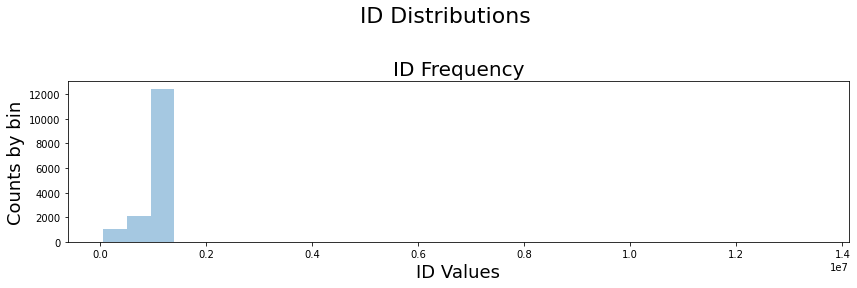

In [140]:
dist_plot(df, 'ID')

- ID is not uniform.

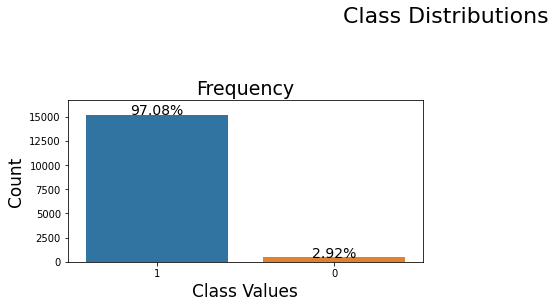

In [141]:
bar_plot(df, target, target_plots=False)

# Features EDA

In [142]:
cols = list(df.columns)

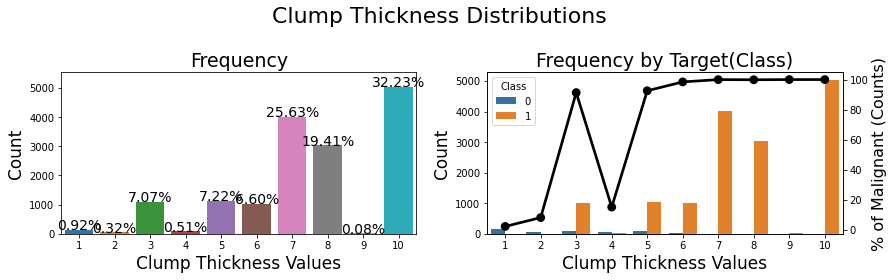

In [143]:
bar_plot(df,cols[1], sorted_plot_order=True, others_threshold=10)

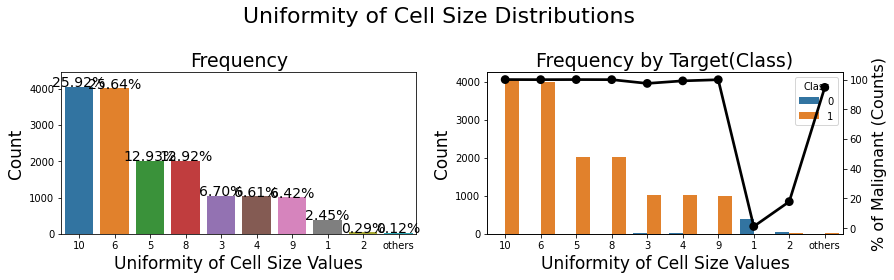

In [144]:
bar_plot(df, cols[2], others_threshold=20)

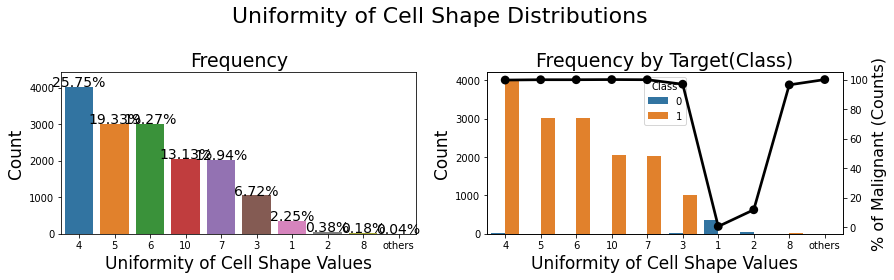

In [145]:
bar_plot(df, cols[3], others_threshold=20)

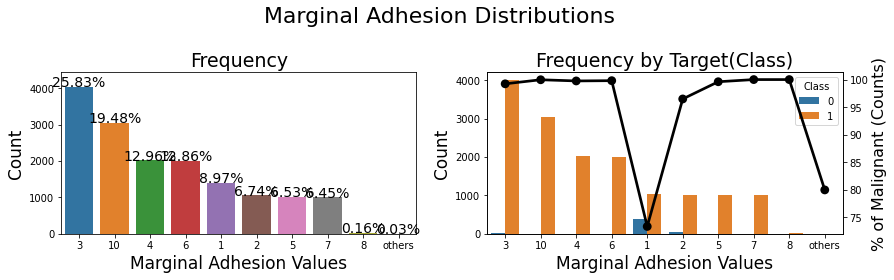

In [146]:
bar_plot(df, cols[4], others_threshold=20)

<a id='addr' />

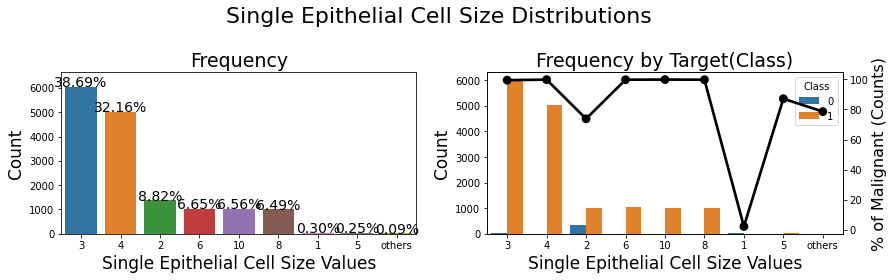

In [147]:
bar_plot(df, cols[5], others_threshold=20)

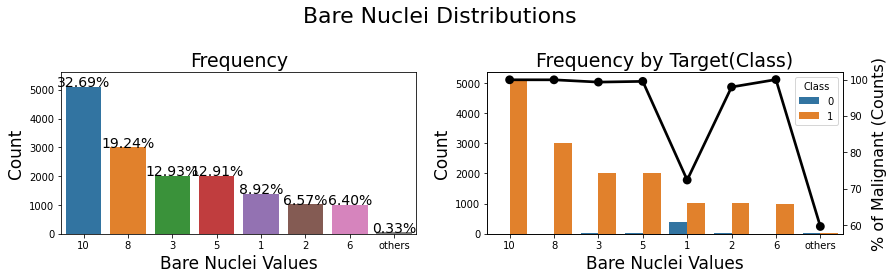

In [148]:
bar_plot(df, cols[6], others_threshold=30)

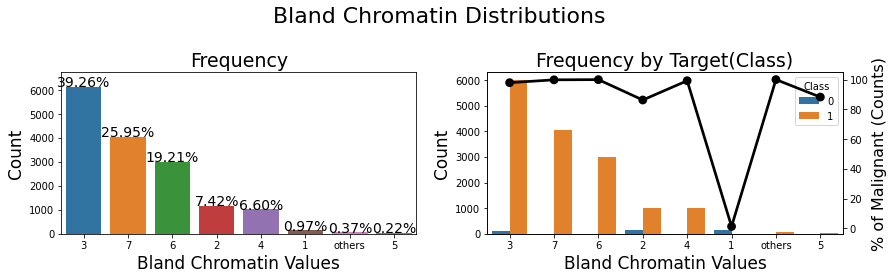

In [150]:
bar_plot(df, cols[7], others_threshold=30)

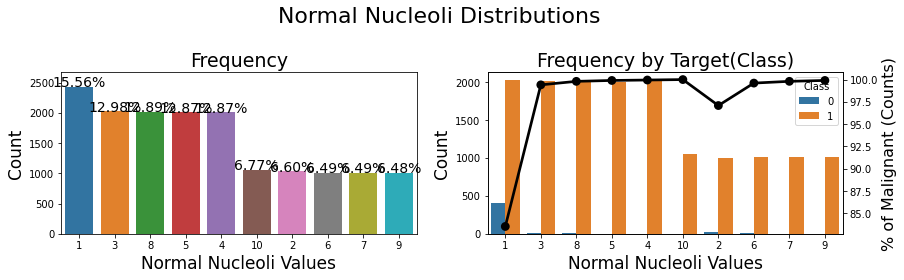

In [151]:
bar_plot(df,cols[8],others_threshold=20)

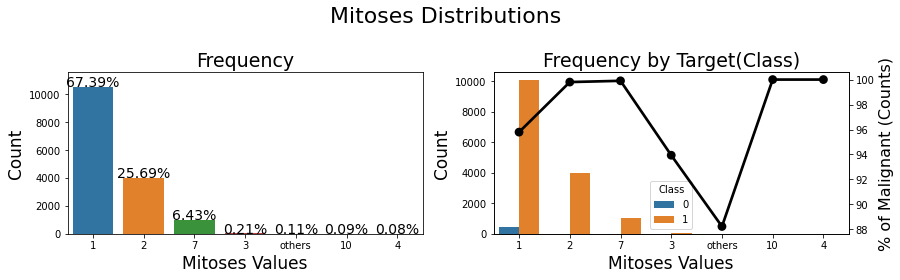

In [152]:
bar_plot(df, cols[9])